In [26]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D
from keras.models import Model
import os
import numpy as np
import pandas as pd
from pyntcloud import PyntCloud
import open3d as o3d

In [27]:
directory = "abc-dataset-ply/"
files = sorted([filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))])
dataset = []

def convert_to_binvox(path):
    point_cloud = np.loadtxt(path, skiprows=12)[:, 0:3]
    df = pd.DataFrame(data=point_cloud, columns=['x','y','z'])
    cloud = PyntCloud(df)
    voxelgrid_id = cloud.add_structure("voxelgrid", n_x=64, n_y=64, n_z=64)
    voxelgrid = cloud.structures[voxelgrid_id]
    Binary_voxel_array = voxelgrid.get_feature_vector(mode="binary")
    dataset.append(Binary_voxel_array)

for i in files:
    path = os.path.join(directory, i)
    convert_to_binvox(path)

In [28]:
# Load your dataset into numpy arrays
dataset = np.array(dataset)

# Split your dataset into train and test datasets
train_dataset = dataset[:100]  # Adjust the number as needed
test_dataset = dataset[100:]   # The remaining data for testing

# Define the input shape
input_shape = (64, 64, 64, 1)

In [29]:
input_data = Input(shape=input_shape)
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(input_data)
x = MaxPooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling3D((2, 2, 2), padding='same')(x)

In [30]:
x = Conv3D(16, (3, 3, 3), activation='relu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

In [42]:
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(train_dataset, train_dataset, epochs=20, batch_size=10, validation_data=(test_dataset, test_dataset))
reconstructed_data = autoencoder.predict(test_dataset)

Epoch 1/20
10/10 [==============================] - 5s 298ms/step - loss: 0.2797 - val_loss: 0.2690
Epoch 2/20
10/10 [==============================] - 3s 282ms/step - loss: 0.2796 - val_loss: 0.2690
Epoch 3/20
10/10 [==============================] - 3s 282ms/step - loss: 0.2446 - val_loss: 0.1009
Epoch 4/20
10/10 [==============================] - 3s 283ms/step - loss: 0.1017 - val_loss: 0.0884
Epoch 5/20
10/10 [==============================] - 3s 284ms/step - loss: 0.0675 - val_loss: 0.0562
Epoch 6/20
10/10 [==============================] - 3s 284ms/step - loss: 0.0566 - val_loss: 0.0494
Epoch 7/20
10/10 [==============================] - 3s 283ms/step - loss: 0.0513 - val_loss: 0.0475
Epoch 8/20
10/10 [==============================] - 3s 283ms/step - loss: 0.0478 - val_loss: 0.0434
Epoch 9/20
10/10 [==============================] - 3s 284ms/step - loss: 0.0449 - val_loss: 0.0410
Epoch 10/20
10/10 [==============================] - 3s 283ms/step - loss: 0.0431 - val_loss: 0.0395

In [43]:
import matplotlib.pyplot as plt

index = 4

original_sample = test_dataset[index]

reconstructed_sample = reconstructed_data[index].reshape(64, 64, 64)
threshold = 0.35  # Adjust the threshold as needed
reconstructed_sample = (reconstructed_sample > threshold).astype(int)

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

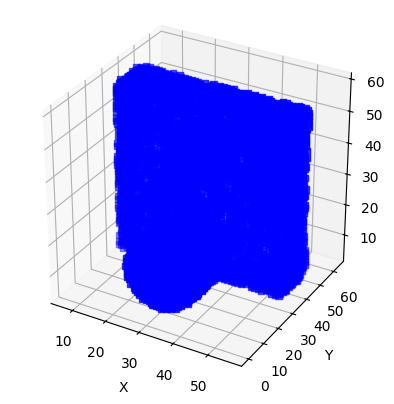

In [45]:
voxel_data = original_sample

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a mesh grid for 3D plotting
x, y, z = np.indices(voxel_data.shape)

# Extract the coordinates where voxel_data is equal to 1
x1, y1, z1 = x[voxel_data == 1], y[voxel_data == 1], z[voxel_data == 1]

# Plot the voxels as points or cubes
ax.scatter(x1, y1, z1, c='b', marker='s')  # Use 'marker='s'' for cubes

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the aspect ratio to be equal to avoid distorted visualization
ax.set_box_aspect([1, 1, 1])

# Show the plot
plt.show()

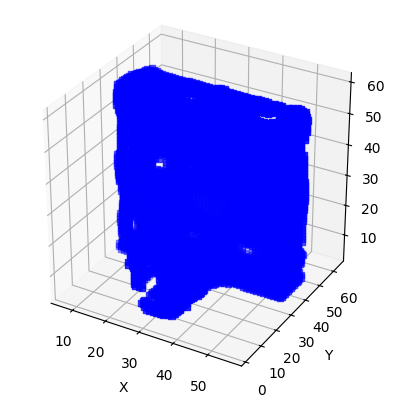

In [46]:
voxel_data = reconstructed_sample

# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a mesh grid for 3D plotting
x, y, z = np.indices(voxel_data.shape)

# Extract the coordinates where voxel_data is equal to 1
x1, y1, z1 = x[voxel_data == 1], y[voxel_data == 1], z[voxel_data == 1]

# Plot the voxels as points or cubes
ax.scatter(x1, y1, z1, c='b', marker='s')  # Use 'marker='s'' for cubes

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the aspect ratio to be equal to avoid distorted visualization
ax.set_box_aspect([1, 1, 1])

# Show the plot
plt.show()

In [36]:
voxel_data = original_sample

# Create a point cloud from the voxel data
x, y, z = np.where(voxel_data == 1)
points = np.column_stack((x, y, z))
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)

# Create a 3D visualization window
visualizer = o3d.visualization.Visualizer()
visualizer.create_window()

# Add the point cloud to the visualization
visualizer.add_geometry(point_cloud)

# Set up the view and rendering options
view_control = visualizer.get_view_control()
view_control.set_front([0, 0, -1])
view_control.set_up([0, 1, 0])

# Run the visualization
visualizer.run()

# Close the visualization window when done
visualizer.destroy_window()

In [37]:
voxel_data = reconstructed_sample

# Create a point cloud from the voxel data
x, y, z = np.where(voxel_data == 1)
points = np.column_stack((x, y, z))
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points)

# Create a 3D visualization window
visualizer = o3d.visualization.Visualizer()
visualizer.create_window()

# Add the point cloud to the visualization
visualizer.add_geometry(point_cloud)

# Set up the view and rendering options
view_control = visualizer.get_view_control()
view_control.set_front([0, 0, -1])
view_control.set_up([0, 1, 0])

# Run the visualization
visualizer.run()

# Close the visualization window when done
visualizer.destroy_window()